<a href="https://colab.research.google.com/github/shawmica/Student_GradePrediction_Model/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Define paths to your Excel files in Google Drive
train_path = '/content/drive/My Drive/train_data (34).xlsx'
val_path = '/content/drive/My Drive/val_data (31).xlsx'

# Load into DataFrames
train_df = pd.read_excel(train_path)
val_df = pd.read_excel(val_path)

# Preview
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)


Train shape: (704, 5)
Validation shape: (151, 5)


features (inputs) and target (output)

In [3]:
# Define your final selected feature columns and target
feature_cols = ['QuizAverage','StudyEfficiency','ParticipationScore','AssignmentPenaltyScore']
target_col = 'EncodedGrade'

# Split features (X) and target (y)
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]


In [4]:
#from sklearn.preprocessing import LabelBinarizer

# Fit label binarizer on training labels
#lb = LabelBinarizer()
#y_train_ohe = lb.fit_transform(y_train)
#y_val_ohe = lb.transform(y_val)


calculates the number of unique classes (labels) in the training dataset

In [5]:
#n_classes = len(y_train.unique())

In [6]:
!pip install -U scikit-learn scikeras scikit-optimize


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

n_classes = len(le.classes_)


customizable neural network architecture

In [8]:

def build_model(learning_rate=0.001, dropout1=0.2, dropout2=0.1,
                neurons1=128, neurons2=64, neurons3=64, neurons4=32,
                l2=1e-4):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
    from tensorflow.keras.optimizers import Adam

    n1 = int(neurons1)
    n2 = int(max(neurons2, n1))
    n3 = int(max(neurons3, n2))
    n4 = int(min(neurons4, n3))

    reg = tf.keras.regularizers.l2(l2)

    model = Sequential([
        Input(shape=(X_train.shape[1],)),

        Dense(n1, kernel_regularizer=reg),
        BatchNormalization(), Activation('relu'),
        Dropout(dropout1),

        Dense(n2, kernel_regularizer=reg),
        BatchNormalization(), Activation('relu'),
        Dropout(dropout2),

        Dense(n3, kernel_regularizer=reg),
        BatchNormalization(), Activation('relu'),

        Dense(n4, kernel_regularizer=reg),
        BatchNormalization(), Activation('relu'),

        Dense(n_classes, activation='softmax')
    ])

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

ensures One model training at a time.

In [9]:
n_jobs=1


Bayesian hyperparameter optimization

In [10]:
from scikeras.wrappers import KerasClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Wrapper (you can also tune epochs/batch_size via BayesSearchCV)
clf = KerasClassifier(
    model=build_model,
    verbose=0,
    random_state=42
)

# Expanded search space for 4 dense layers
search_space = {
    'model__learning_rate': Real(1e-5, 1e-2, prior='log-uniform'),
    'model__dropout1': Real(0.1, 0.5),
    'model__dropout2': Real(0.1, 0.5),
    'model__neurons1': Integer(64, 256),
    'model__neurons2': Integer(32, 128),
    'model__neurons3': Integer(32, 128),
    'model__neurons4': Integer(16, 96),

    # Also tune training dynamics
    'batch_size': Integer(8, 64),
    'epochs': Integer(40, 120),
}

opt = BayesSearchCV(
    estimator=clf,
    search_spaces=search_space,
    n_iter=20,          # you can increase to 30–50 if time permits
    scoring='accuracy',
    cv=3,
    n_jobs=1,           # keep 1 for Colab stability with TF
    verbose=2,
    random_state=42
)

opt.fit(X_train, y_train_enc)

print(" Best Parameters Found:")
print(opt.best_params_)
print("Best CV Accuracy:", opt.best_score_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END batch_size=31, epochs=98, model__dropout1=0.47314719953913353, model__dropout2=0.2263198373948195, model__learning_rate=0.0010243393225105074, model__neurons1=144, model__neurons2=66, model__neurons3=103, model__neurons4=40; total time=  28.8s
[CV] END batch_size=31, epochs=98, model__dropout1=0.47314719953913353, model__dropout2=0.2263198373948195, model__learning_rate=0.0010243393225105074, model__neurons1=144, model__neurons2=66, model__neurons3=103, model__neurons4=40; total time=  17.7s


[CV] END batch_size=31, epochs=98, model__dropout1=0.47314719953913353, model__dropout2=0.2263198373948195, model__learning_rate=0.0010243393225105074, model__neurons1=144, model__neurons2=66, model__neurons3=103, model__neurons4=40; total time=  20.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[CV] END batch_size=55, epochs=111, model__dropout1=0.22136404395367001, model__dropout2=0.4804895626373318, model__learning_rate=0.0039118639884156686, model__neurons1=76, model__neurons2=45, model__neurons3=66, model__neurons4=67; total time=  17.4s
[CV] END batch_size=55, epochs=111, model__dropout1=0.22136404395367001, model__dropout2=0.4804895626373318, model__learning_rate=0.0039118639884156686, model__neurons1=76, model__neurons2=45, model__neurons3=66, model__neurons4=67; total time=  18.7s
[CV] END batch_size=55, epochs=111, model__dropout1=0.22136404395367001, model__dropout2=0.4804895626373318, model__learning_rate=0.0039118639884156686, model__neurons1=76, model__neurons2=45, model__neurons3=66, model__neurons4=67; total time=  19.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END batch_size=33, epochs=113, model__dropout1=0.14194366342108145, model__dropout2=0.2733331207480901, model__learning_rate=3.663241571989203e-05, model__neurons1=151, model__neur

In [11]:
import tensorflow as tf
import numpy as np
import random

# Set a global seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)


training final model using the best hyperparameters found

In [12]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Set seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Extract best hyperparameters
best_params = opt.best_params_

# Build final model
final_model = build_model(
    learning_rate=best_params['model__learning_rate'],
    dropout1=best_params['model__dropout1'],
    dropout2=best_params['model__dropout2'],
    neurons1=best_params['model__neurons1'],
    neurons2=best_params['model__neurons2'],
    neurons3=best_params['model__neurons3'],
    neurons4=best_params['model__neurons4']
)

# Add early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
lr_sched = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train final model
history = final_model.fit(
    X_train, y_train_enc,
    validation_data=(X_val, y_val_enc),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/103
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3608 - loss: 1.5046 - val_accuracy: 0.2649 - val_loss: 3.7137
Epoch 2/103
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4950 - loss: 1.1614 - val_accuracy: 0.2848 - val_loss: 2.4944
Epoch 3/103
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5847 - loss: 1.0294 - val_accuracy: 0.3046 - val_loss: 1.6591
Epoch 4/103
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5715 - loss: 1.0231 - val_accuracy: 0.3576 - val_loss: 1.3898
Epoch 5/103
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6474 - loss: 0.8998 - val_accuracy: 0.4172 - val_loss: 1.2067
Epoch 6/103
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6770 - loss: 0.8690 - val_accuracy: 0.4570 - val_loss: 1.0787
Epoch 7/103
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6746 - loss: 0.8001 - val_accuracy: 0.5695 - val_loss: 0.9268
Epoch 8/103
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6874 - loss: 0.7778 - val_accuracy: 0.5497 -

In [13]:
# Final evaluation on validation data
val_loss, val_accuracy = final_model.evaluate(X_val, y_val_enc, verbose=0)
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Evaluation on training data
train_loss, train_accuracy = final_model.evaluate(X_train, y_train_enc, verbose=0)
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")


Final Validation Accuracy: 0.8477
Final Validation Loss: 0.5058
Final Training Accuracy: 0.8580
Final Training Loss: 0.4150


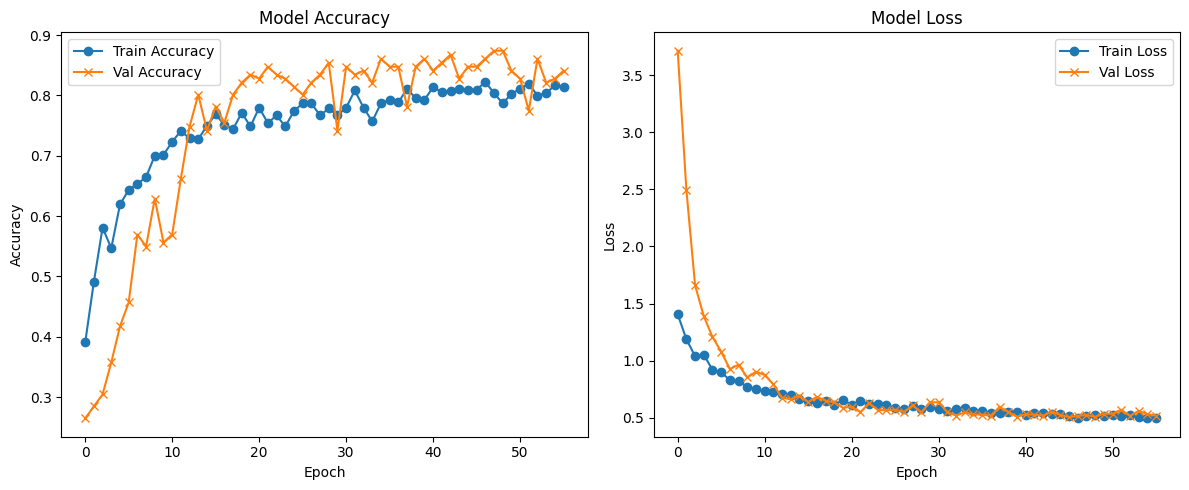

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


test data

In [15]:
# Load test dataset
test_path = '/content/drive/My Drive/test_data (31).xlsx'
test_df = pd.read_excel(test_path)
print("Test shape:", test_df.shape)

# Extract features and target
X_test = test_df[feature_cols]
y_test = test_df[target_col]
y_test_enc = le.transform(y_test)


Test shape: (152, 5)


evaluate your trained model on the test set

In [16]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Predict probabilities
y_test_pred_proba = final_model.predict(X_test)

# Predicted class labels
y_test_pred = np.argmax(y_test_pred_proba, axis=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


classification metrics

In [17]:
# Evaluate
accuracy = accuracy_score(y_test_enc, y_test_pred)
precision_macro = precision_score(y_test_enc, y_test_pred, average='macro')
recall_macro = recall_score(y_test_enc, y_test_pred, average='macro')
f1_macro = f1_score(y_test_enc, y_test_pred, average='macro')

precision_weighted = precision_score(y_test_enc, y_test_pred, average='weighted')
recall_weighted = recall_score(y_test_enc, y_test_pred, average='weighted')
f1_weighted = f1_score(y_test_enc, y_test_pred, average='weighted')

print("\n Test Set Evaluation Metrics:")
print(f"Accuracy:            {accuracy:.4f}")
print(f"Macro Precision:     {precision_macro:.4f}")
print(f"Macro Recall:        {recall_macro:.4f}")
print(f"Macro F1 Score:      {f1_macro:.4f}")
print(f"Weighted Precision:  {precision_weighted:.4f}")
print(f"Weighted Recall:     {recall_weighted:.4f}")
print(f"Weighted F1 Score:   {f1_weighted:.4f}")



 Test Set Evaluation Metrics:
Accuracy:            0.8487
Macro Precision:     0.8512
Macro Recall:        0.8487
Macro F1 Score:      0.8484
Weighted Precision:  0.8512
Weighted Recall:     0.8487
Weighted F1 Score:   0.8484


In [18]:
test_loss, test_accuracy = final_model.evaluate(X_test, y_test_enc, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.8487
Test Loss: 0.4711


<Figure size 600x500 with 0 Axes>

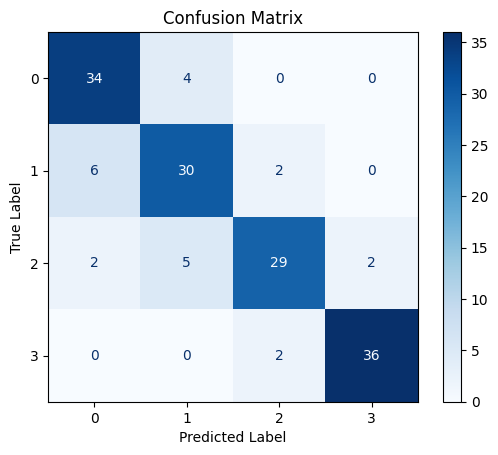

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make sure you've already predicted the test set
# y_test_pred = np.argmax(pred_probs, axis=1)
# y_test_enc = le.transform(y_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test_enc, y_test_pred)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot it
plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


In [20]:
# After splitting your data into X_train, X_val, and X_test
# Compute and save normalization stats for X_train
np.save('/content/drive/MyDrive/train_feature_means.npy', X_train.mean().values)
np.save('/content/drive/MyDrive/train_feature_stds.npy', X_train.std(ddof=0).values)

# Save the label classes
np.save('/content/drive/MyDrive/grade_label_classes.npy', le.classes_)

# Save the trained model
final_model.save('/content/optimized_final_grade_model1.h5')

# Move model to Google Drive
!cp /content/optimized_final_grade_model.h5 /content/drive/MyDrive/


cp: cannot stat '/content/optimized_final_grade_model.h5': No such file or directory
